In [51]:
'''
Library declare
@Author: MinHyung Lee
@Since: 2022/05/22
Used library:
pandas
numpy
featuretools
matplot
sklearn
seaborn

'''

import pandas as pd
import numpy as np
import featuretools as ft
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import  r_regression, SelectKBest
from sklearn.pipeline import make_pipeline


from woodwork.logical_types import Categorical, Boolean
from sklearn.preprocessing import OrdinalEncoder
from datetime import datetime
from math import sqrt, log10, ceil
'''
Add plt config
@Author: MinHyung Lee
@Since: 2022/05/24

'''

import matplotlib.ticker as ticker
plt.style.use('ggplot')
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['figure.figsize'] = [12, 9]
rcParams['font.size'] = 16
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
rcParams['figure.dpi'] = 600

pd.set_option('display.max_rows', 20)

In [77]:


df = pd.read_csv('Google-Playstore(new).csv')

# 필요없는 컬럼 버리기
df = df.drop(['Unnamed: 0', 'App Name', 'App Id', 'Minimum Installs', 'Price', 'Currency', 'Developer Id', 'Developer Website', 'Developer Email', 'Privacy Policy', 'Last Updated', 'Editors Choice', 'Scraped Time', 'Free', 'Rating Count', 'Rating'], axis=1)

# 숫자로 되어 있지 않은 컬럼 숫자로 인코딩하기
encoding = OrdinalEncoder()
encoding.fit(df[['Category', 'Minimum Android', 'Content Rating', 'Ad Supported', 'In App Purchases', 'Installs']])
df[['Category', 'Minimum Android', 'Content Rating', 'Ad Supported', 'In App Purchases', 'Installs']] = encoding.transform(df[['Category', 'Minimum Android', 'Content Rating', 'Ad Supported', 'In App Purchases', 'Installs']])

# Size 컬럼 인코딩
A = df[df['Size'] == 'Varies with device'].index
df = df.drop(A,axis='index')
df = df.dropna()  # NaN가 포함된 데이터는 모두 drop
# 앱 크기 사이즈 계산
# 1. ','drop
# 2. M과 k drop
# 3. k값 M으로 치환
df['Size'] =  np.where(df['Size'].str.contains('M'), df['Size'].str.replace(',','').str[:-1].astype('float64') , df['Size'].str.replace(',','').str[:-1].astype('float64')/1000)

# 날짜 월만 남기고 버리고 인코딩
df['Released'] = pd.to_datetime(df['Released'])
df['Released'].dt.strftime('%b %d, %Y')
df['Released'] = df['Released'].dt.strftime('%Y-%m-%d')

df.fillna(df.mean(), inplace=True)

test_df = df.copy()

df.drop(['Installs'], axis= 1, inplace=True)

In [78]:
test_df

Category  Installs  Maximum Installs  Size  Minimum Android  \
0          38.0       3.0           1148432  56.0             14.0   
1           2.0      14.0                89  13.0             14.0   
3          11.0       9.0            245946  65.0              7.0   
4          15.0      12.0              5360   1.0              4.0   
5          11.0      15.0             86182  92.0             17.0   
...         ...       ...               ...   ...              ...   
19995      32.0       5.0                31   9.8             14.0   
19996      24.0       9.0            119190  15.0             14.0   
19997      19.0      17.0               703  25.0             15.0   
19998      11.0      14.0                63  70.0             14.0   
19999      28.0       8.0               155   6.0             13.0   

         Released  Content Rating  Ad Supported  In App Purchases  
0      2019-12-30             3.0           1.0               0.0  
1      2020-05-09             0.0           1.0               0.0  
3      2016-01-14             0.0           1.0               1.0  
4      2016-03-24             0.0           0.0               0.0  
5      2016-04-25             0.0           1.0               1.0  
...           ...             ...           ...               ...  
19995  2021-06-04             0.0           1.0               0.0  
19996  2016-04-22             0.0           1.0               0.0  
19997  2021-01-12             0.0           0.0               0.0  
19998  2018-06-25             0.0           0.0               0.0  
19999  2019-05-04             0.0           1.0               0.0  

[18777 rows x 9 columns]

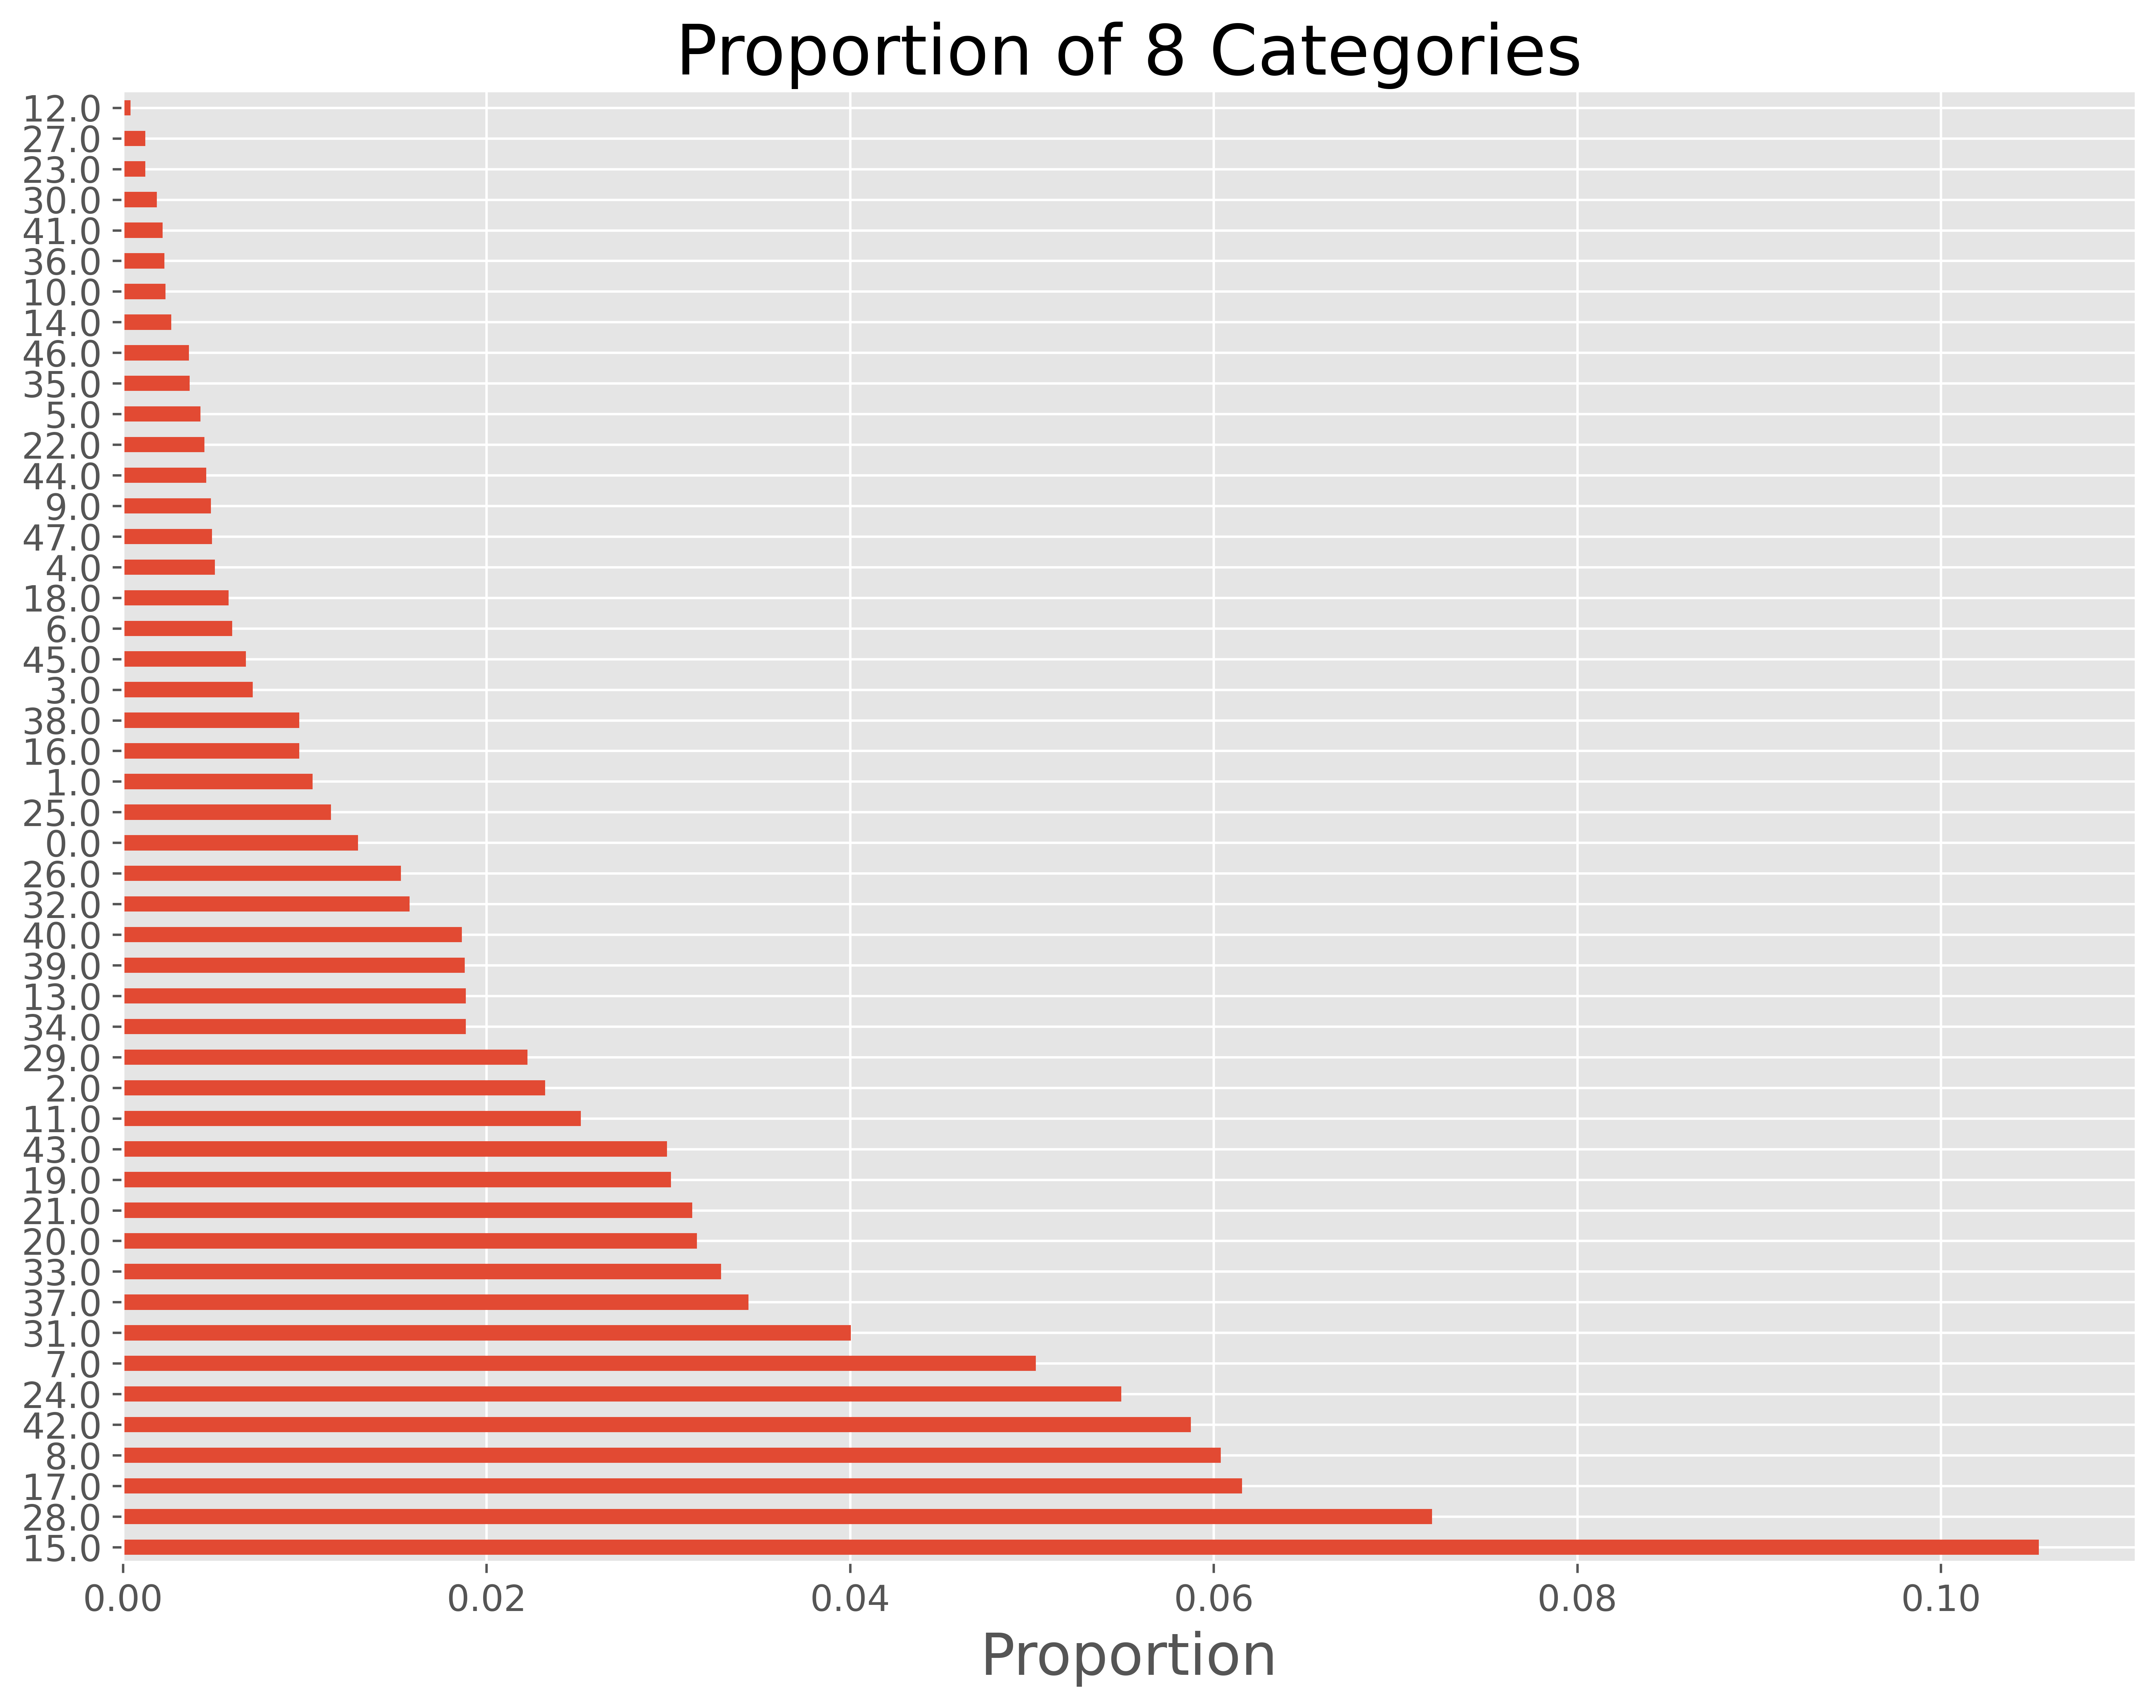

In [79]:
fig, ax = plt.subplots()

# Plot a normalized countplot
df['Category'].value_counts(normalize=True).plot.barh()

# Label
ax.set(title='Proportion of 8 Categories',
       xlabel='Proportion', ylabel='')

plt.show();


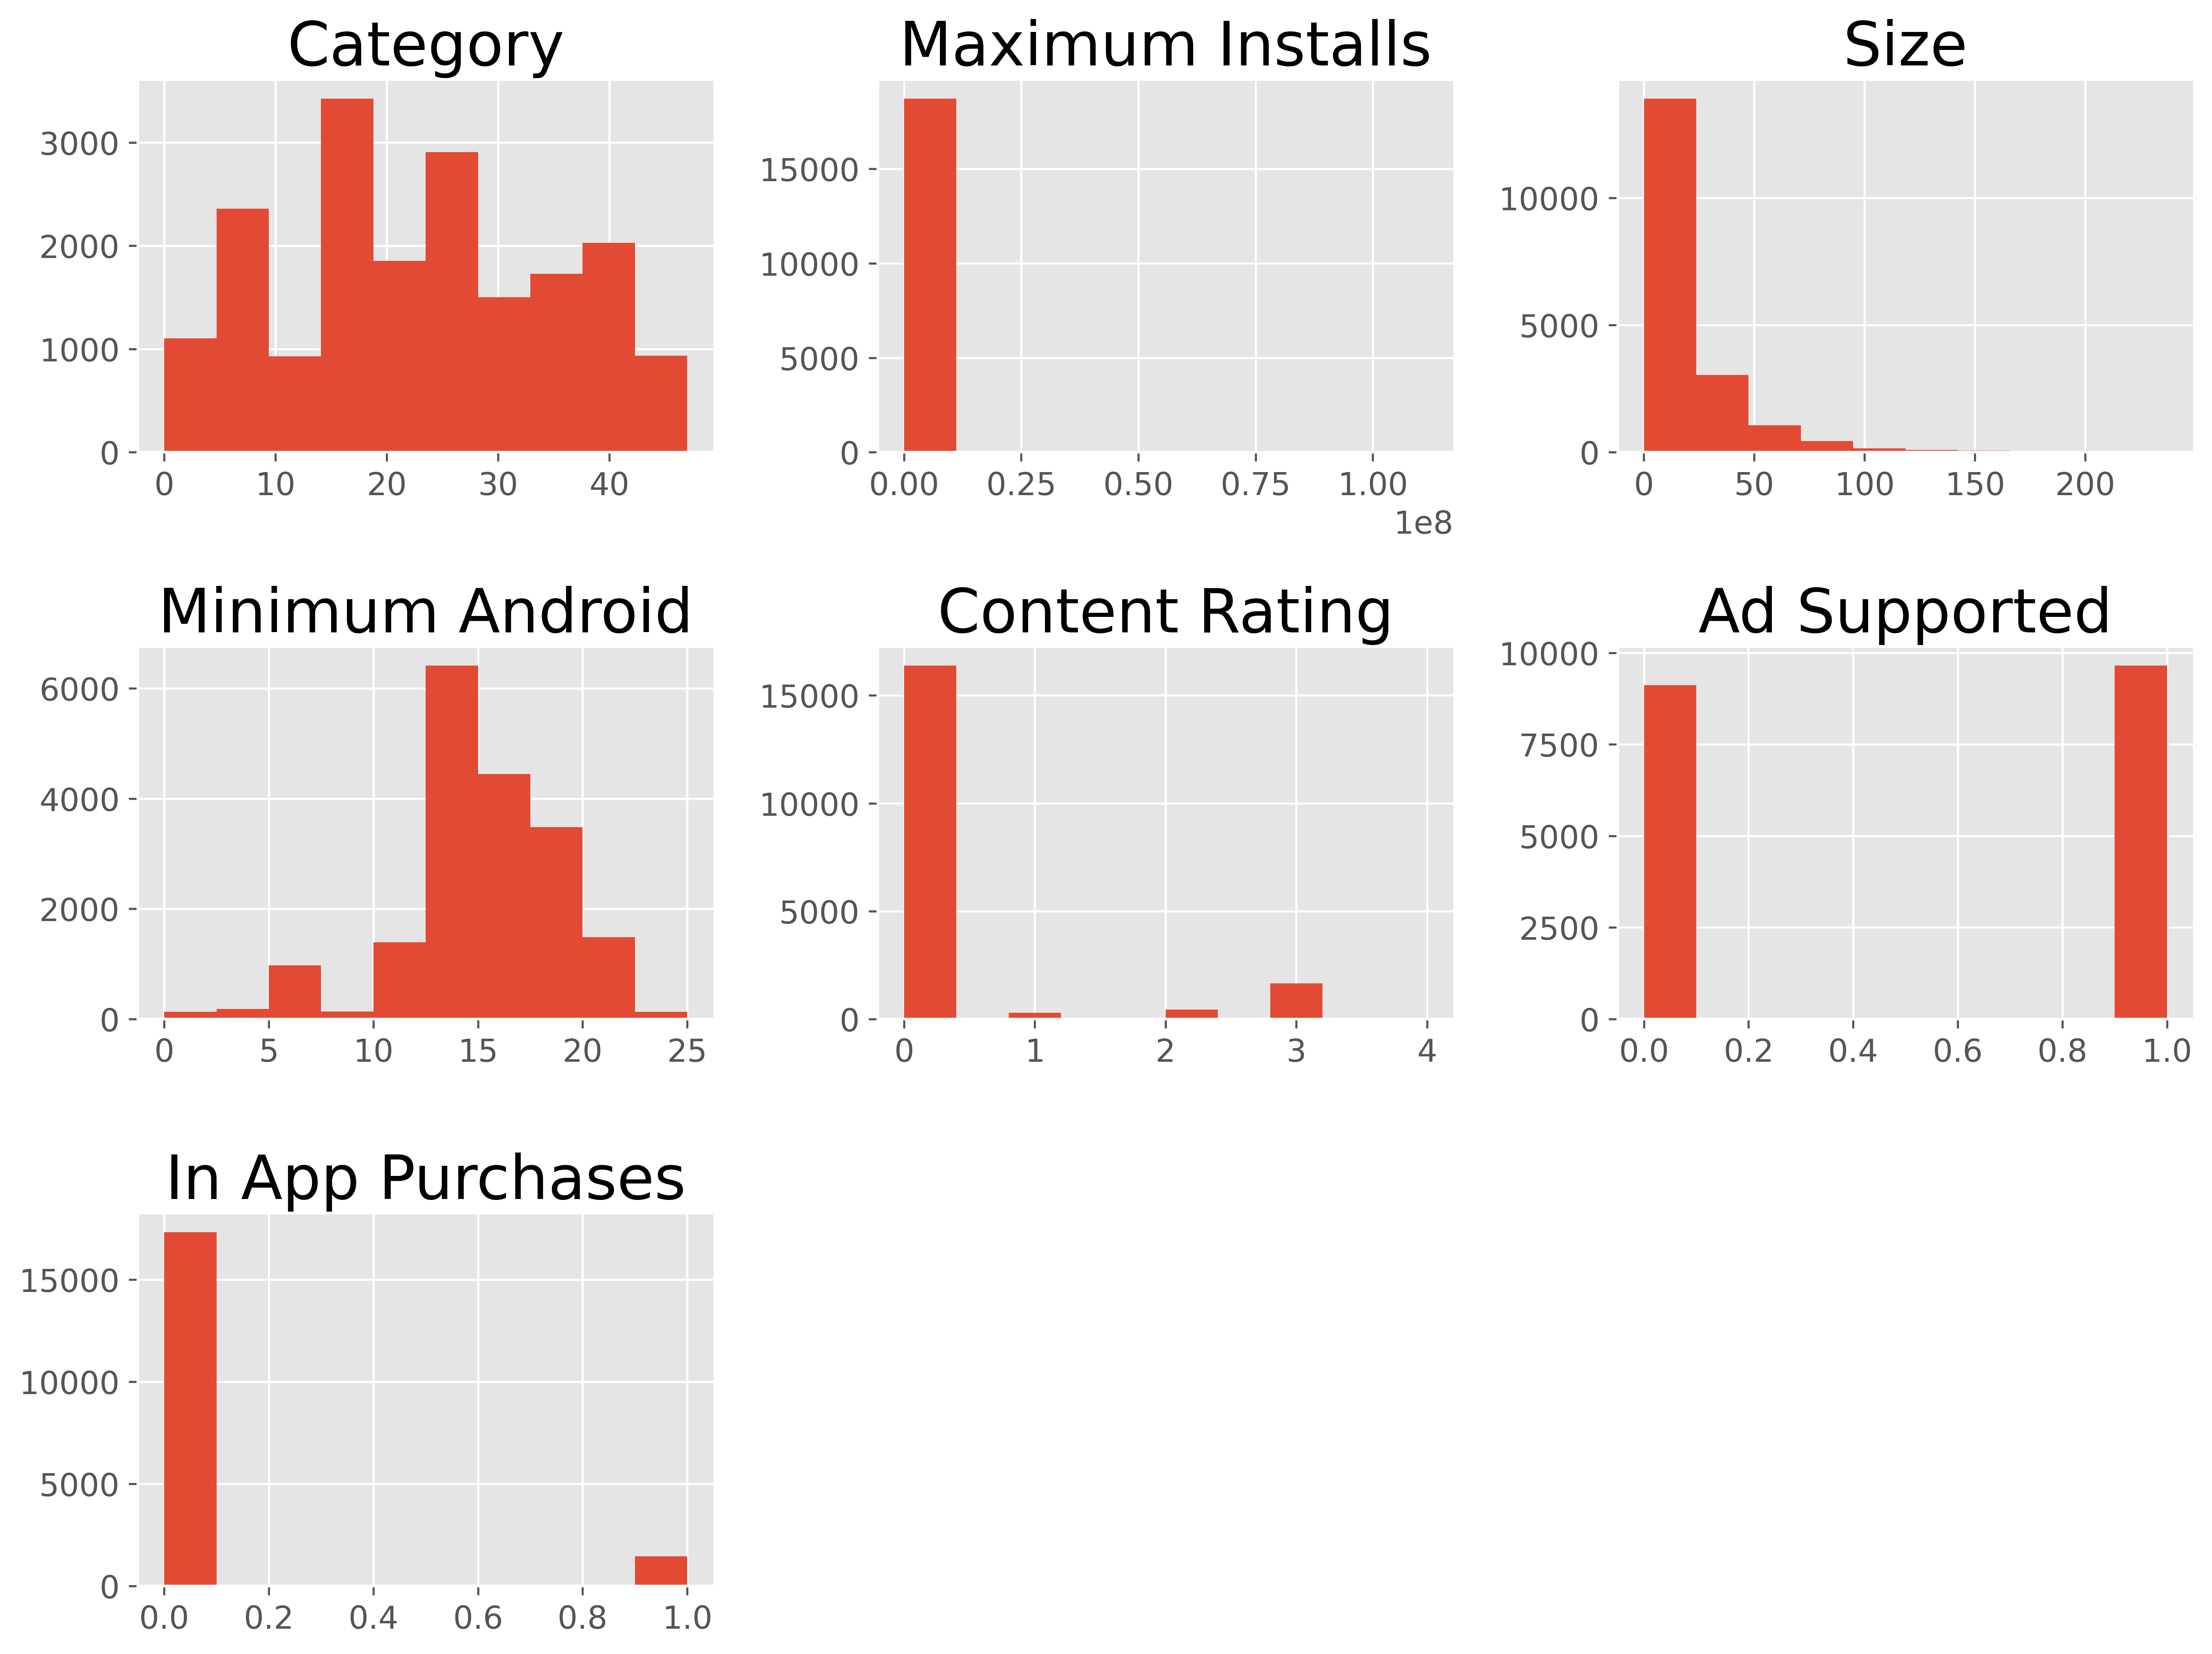

In [80]:
def make_subplot_layout(df, col_num):
    k = len(df.columns)
    row_num = ceil(k/col_num)
    for i in range(k) :
        plt.subplot(row_num,col_num,i+1)
        plt.hist(df.iloc[:,i])
        plt.title(df.columns[i])
    plt.tight_layout()
    plt.show()

make_subplot_layout(df.drop('Released', axis=1, inplace=False), 3)

In [81]:
es = ft.EntitySet(id='Store')
df["index"] = df.index

In [82]:
es.add_dataframe(dataframe_name="store_log",
                 dataframe=df,
                 index="index",
                 logical_types= {
                     "Ad Supported": Boolean,
                     "In App Purchases": Boolean,
                     "Category": Categorical,
                     "Minimum Android": Categorical
                 })

Entityset: Store
  DataFrames:
    store_log [Rows: 18777, Columns: 9]
  Relationships:
    No relationships

In [83]:
#Check dataset schema briefly
es["store_log"].ww.schema

Logical Type Semantic Tag(s)
Column                                       
Category          Categorical    ['category']
Maximum Installs      Integer     ['numeric']
Size                   Double     ['numeric']
Minimum Android   Categorical    ['category']
Released             Datetime              []
Content Rating         Double     ['numeric']
Ad Supported          Boolean              []
In App Purchases      Boolean              []
index                 Integer       ['index']

In [84]:
pd.set_option('display.max_rows', 20)
ft.list_primitives()

name         type  dask_compatible  spark_compatible  \
0                       skew  aggregation            False             False   
1              n_most_common  aggregation            False             False   
2                 num_unique  aggregation             True              True   
3           time_since_first  aggregation            False             False   
4                        all  aggregation             True             False   
..                       ...          ...              ...               ...   
96            num_characters    transform             True              True   
97        less_than_equal_to    transform             True              True   
98                url_to_tld    transform            False             False   
99   multiply_numeric_scalar    transform             True              True   
100                longitude    transform            False             False   

                                           description  \
0    Computes the extent to which a distribution di...   
1             Determines the `n` most common elements.   
2    Determines the number of distinct values, igno...   
3    Calculates the time elapsed since the first da...   
4       Calculates if all values are 'True' in a list.   
..                                                 ...   
96    Calculates the number of characters in a string.   
97   Determines if values in one list are less than...   
98           Determines the top level domain of a url.   
99      Multiply each element in the list by a scalar.   
100  Returns the second tuple value in a list of La...   

                                          valid_inputs return_type  
0         <ColumnSchema (Semantic Tags = ['numeric'])>        None  
1        <ColumnSchema (Semantic Tags = ['category'])>        None  
2        <ColumnSchema (Semantic Tags = ['category'])>        None  
3    <ColumnSchema (Logical Type = Datetime) (Seman...        None  
4    <ColumnSchema (Logical Type = Boolean)>, <Colu...        None  
..                                                 ...         ...  
96     <ColumnSchema (Logical Type = NaturalLanguage)>        None  
97   <ColumnSchema (Logical Type = Ordinal: None)>,...        None  
98                 <ColumnSchema (Logical Type = URL)>        None  
99        <ColumnSchema (Semantic Tags = ['numeric'])>        None  
100            <ColumnSchema (Logical Type = LatLong)>        None  

[101 rows x 7 columns]

In [85]:
'''

@Author: MinHyung Lee
@Since: 2022/05/23
새로운 feature(년, 월, 일)생성하기 위해 dfs 사용

'''


features, feature_names = ft.dfs(entityset=es,
                                 target_dataframe_name='store_log',
                                 trans_primitives=['year', 'month', 'day'])

df = features


## SelectKBest
- 아래 cell은 selectkBest에서 r_regression을 score function으로 사용하고 있음
- 왜 score function으로 r_regression을 사용하였고
- 왜 selectKBest를 사용하였는지 찾아서 언급 바람

In [86]:
X = df.drop(["Maximum Installs"], axis = 1)
y = df[['Maximum Installs']]

select = SelectKBest(score_func= r_regression, k = "all")
fit = select.fit(X, y)

df_columns = pd.DataFrame(X.columns)
df_scores = pd.DataFrame(fit.scores_)

featureScores = pd.concat([df_columns, df_scores], axis = 1)
featureScores.columns = ["Factors", 'Score']
print(featureScores.nlargest(10,'Score'))

            Factors     Score
5  In App Purchases  0.144570
1              Size  0.070429
4      Ad Supported  0.050030
2   Minimum Android  0.015256
6     DAY(Released)  0.011839
3    Content Rating  0.009006
0          Category  0.007639
7   MONTH(Released) -0.005589
8    YEAR(Released) -0.079188


## PCA
- pca 진행 후 기존 9개 에서 8개로 feature가 줄었음
- Scaler algorithm으로 StandardScaler를 사용하였음
- 왜 feature가 줄었고 왜 해당 scaler을 사용했는지 언급 바람

In [100]:
X = StandardScaler().fit_transform(X)

pca = PCA(.90) # 주성분을 몇개로 할지 결정
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data=principalComponents)
principalDf.head()

0         1         2         3         4         5         6  \
0 -0.387561  2.130942  0.116994  1.114261  0.440386 -3.120997  0.947981   
1 -0.061287  0.243283 -0.929763 -1.807451 -0.620068  0.440975 -0.951894   
2  0.787389  3.465327  0.713479  0.148394 -1.209125  3.191729  0.323027   
3  2.412935 -0.693811 -0.195518  0.134236 -1.910119  0.805538  1.160757   
4 -1.184417  3.676533  2.108528  0.780264 -1.440315  1.965658 -0.189708   

          7  
0  1.484221  
1 -0.052441  
2  0.307647  
3  0.107634  
4  0.350583

In [94]:
#Split dataset into train and test set seed to 7777 for same result

X_train, X_test, y_train,  y_test = train_test_split(principalDf, y, test_size = 0.2, random_state=7777)

In [95]:
reg = LinearRegression()
reg.fit(X_train, y_train)

y_predict_test = reg.predict(X_test)
print(log10(mean_squared_error(y_test, y_predict_test)))

12.82877847654323


RMSE value for k=  1 is: 79265787378.08147
RMSE value for k=  2 is: 584658148893.1566
RMSE value for k=  3 is: 1655717343362.162
RMSE value for k=  4 is: 2603949485831.019
RMSE value for k=  5 is: 3471107355568.8
RMSE value for k=  6 is: 4552200843573.502
RMSE value for k=  7 is: 5220041502625.086
RMSE value for k=  8 is: 5218742975347.47
RMSE value for k=  9 is: 5286919200120.143
RMSE value for k=  10 is: 5367450666304.625
RMSE value for k=  11 is: 5436217209204.445
RMSE value for k=  12 is: 5528764524845.16
RMSE value for k=  13 is: 5586030272863.101
RMSE value for k=  14 is: 5672251848795.198
RMSE value for k=  15 is: 5659675725509.917
RMSE value for k=  16 is: 5619653682474.484
RMSE value for k=  17 is: 5622977910571.8
RMSE value for k=  18 is: 5689208384389.234
RMSE value for k=  19 is: 5727301970277.161
RMSE value for k=  20 is: 5782584829916.236
RMSE value for k=  21 is: 5817830481770.307
RMSE value for k=  22 is: 5857307542054.212
RMSE value for k=  23 is: 5893618206901.348
RMS

<AxesSubplot:>

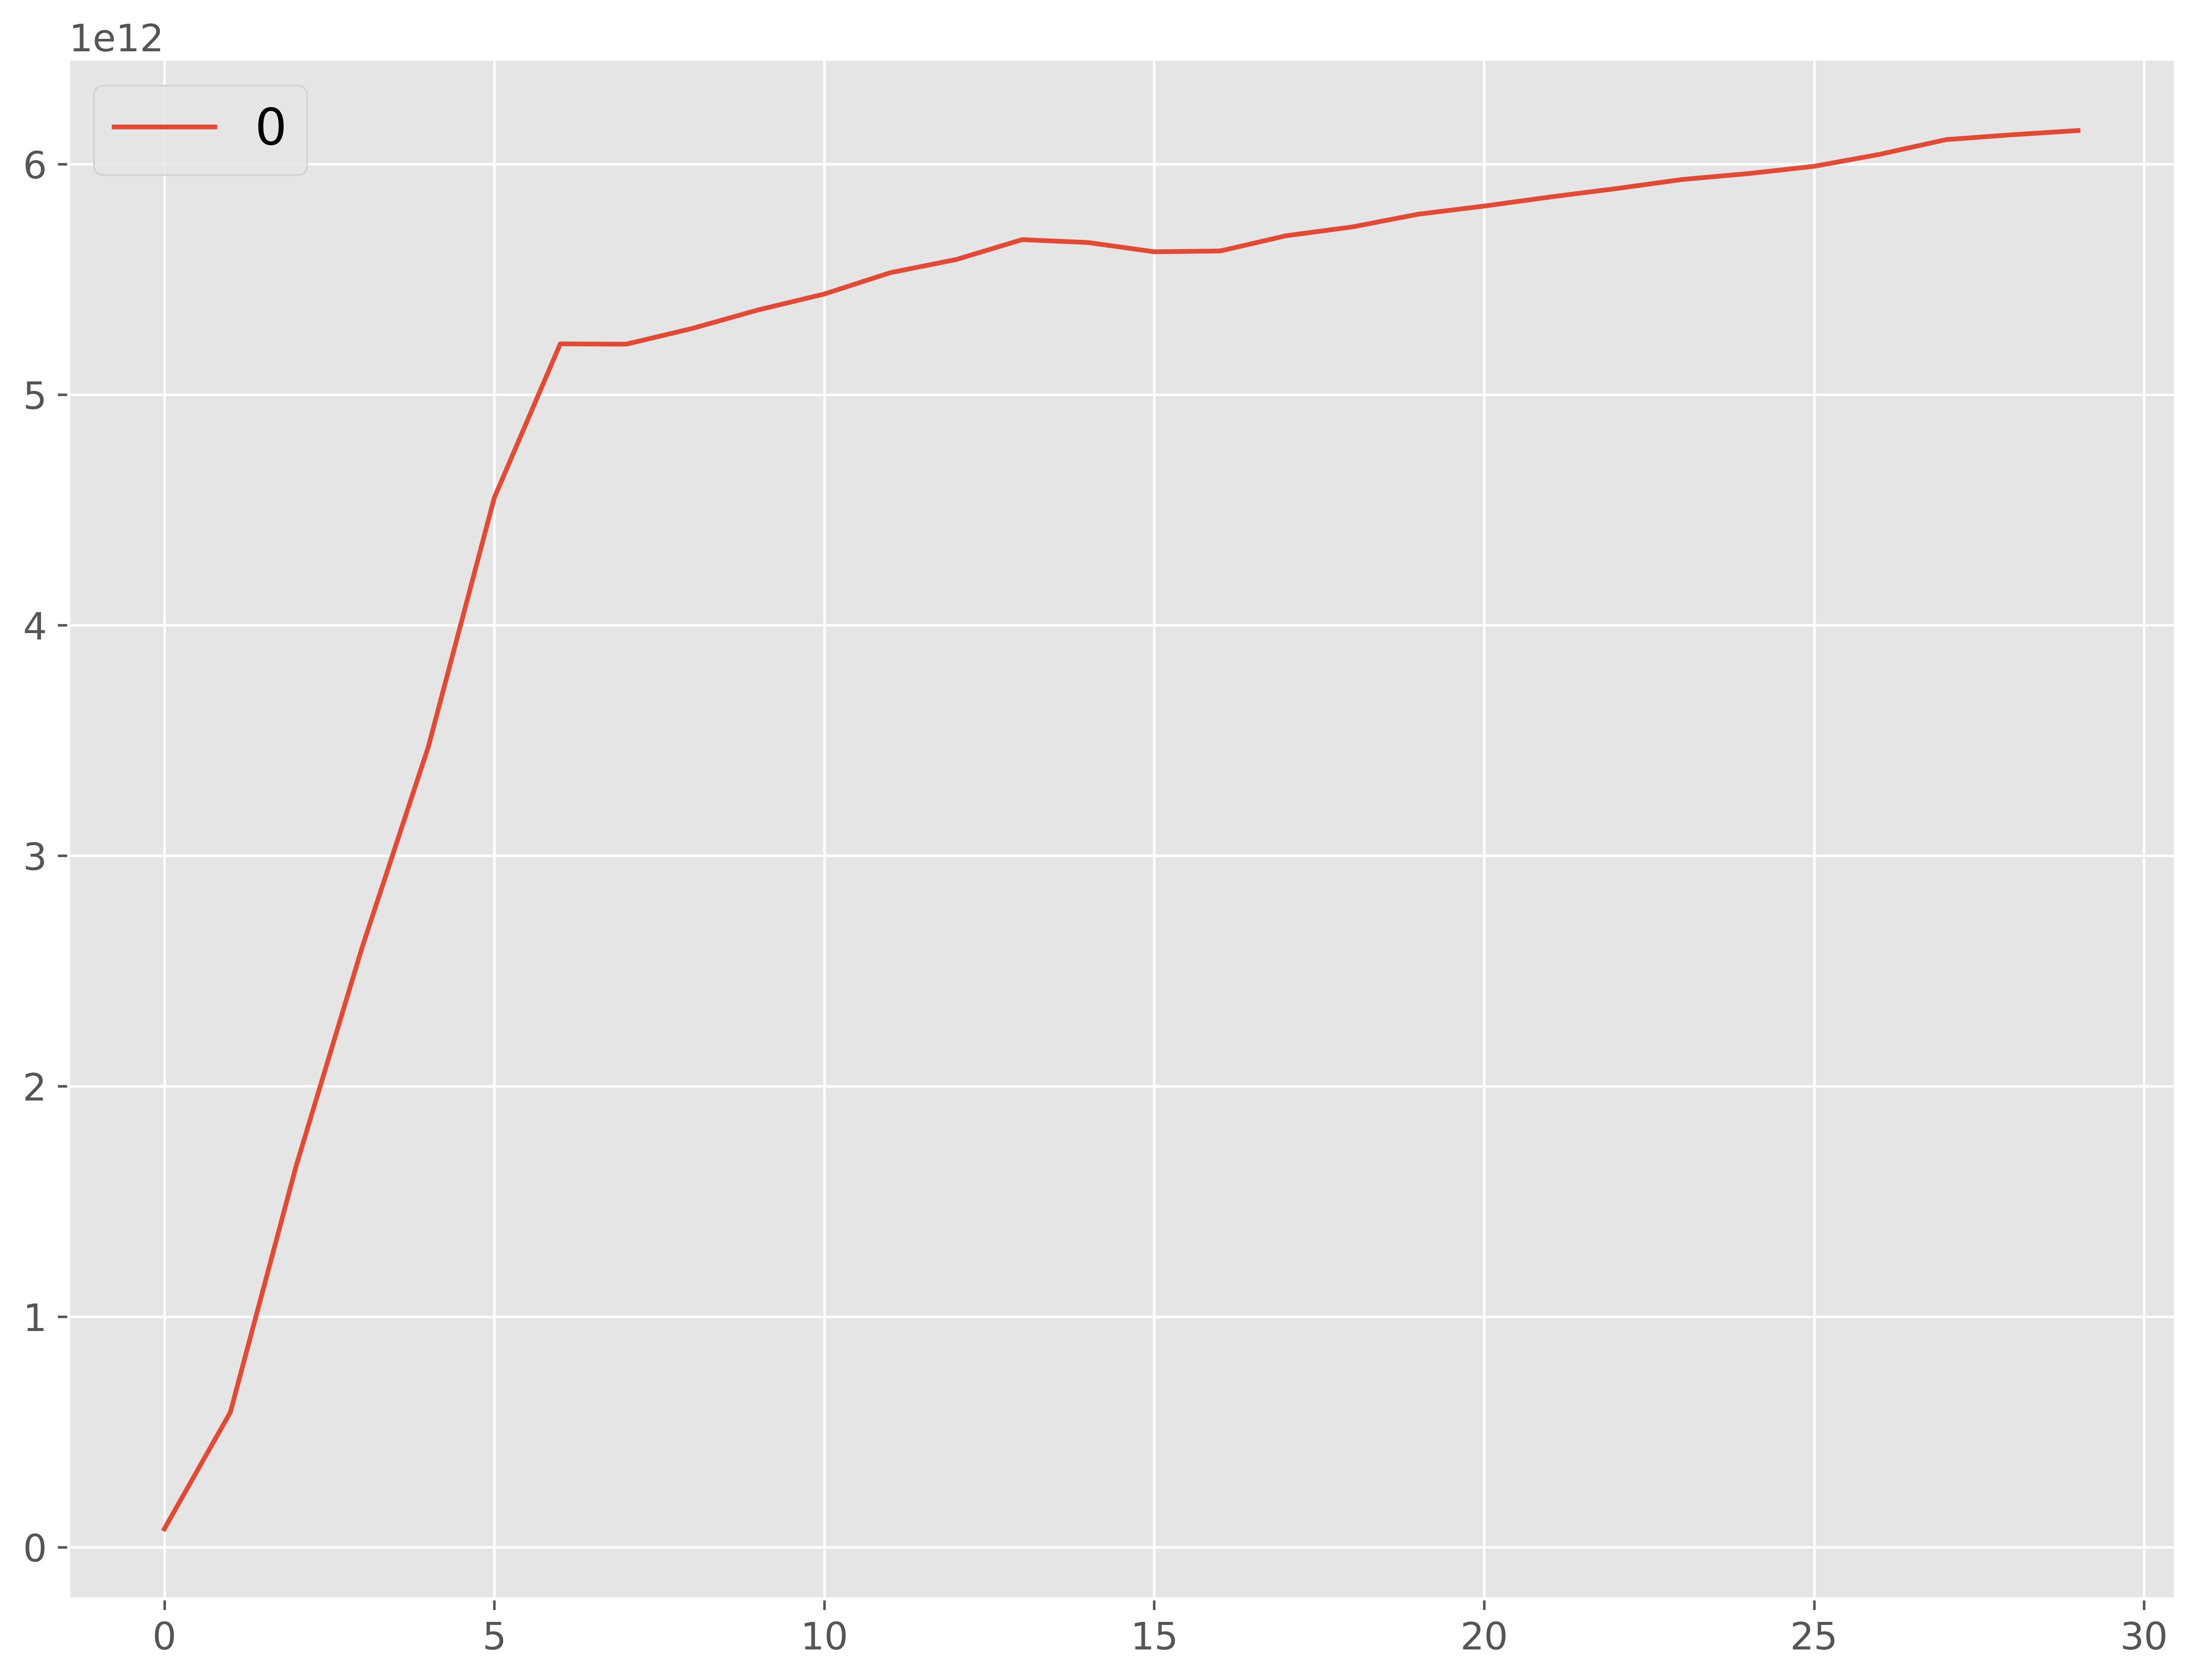

In [96]:
# Normal MSE

rmse_val = [] #to store rmse values for different k
for K in range(30):
    K = K+1
    model = KNeighborsRegressor(n_neighbors = K)
    model.fit(X_train, y_train)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = mean_squared_error(y_test,pred) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

curve = pd.DataFrame(rmse_val) #elbow curve
curve.plot()

RMSE value for k=  1 is: 10.899085777998268
RMSE value for k=  2 is: 11.76690200720264
RMSE value for k=  3 is: 12.218986197970791
RMSE value for k=  4 is: 12.415632555073714
RMSE value for k=  5 is: 12.540468045884067
RMSE value for k=  6 is: 12.658221414927322
RMSE value for k=  7 is: 12.717673955931268
RMSE value for k=  8 is: 12.717565908249016
RMSE value for k=  9 is: 12.723202673141992
RMSE value for k=  10 is: 12.729768061408214
RMSE value for k=  11 is: 12.73529680105426
RMSE value for k=  12 is: 12.742628093332092
RMSE value for k=  13 is: 12.747103284981486
RMSE value for k=  14 is: 12.753755505340353
RMSE value for k=  15 is: 12.752791548740202
RMSE value for k=  16 is: 12.749709552504182
RMSE value for k=  17 is: 12.749966377420906
RMSE value for k=  18 is: 12.755051841402315
RMSE value for k=  19 is: 12.75795008176319
RMSE value for k=  20 is: 12.762122012544134
RMSE value for k=  21 is: 12.764761062750797
RMSE value for k=  22 is: 12.767698027564004
RMSE value for k=  23 

<AxesSubplot:>

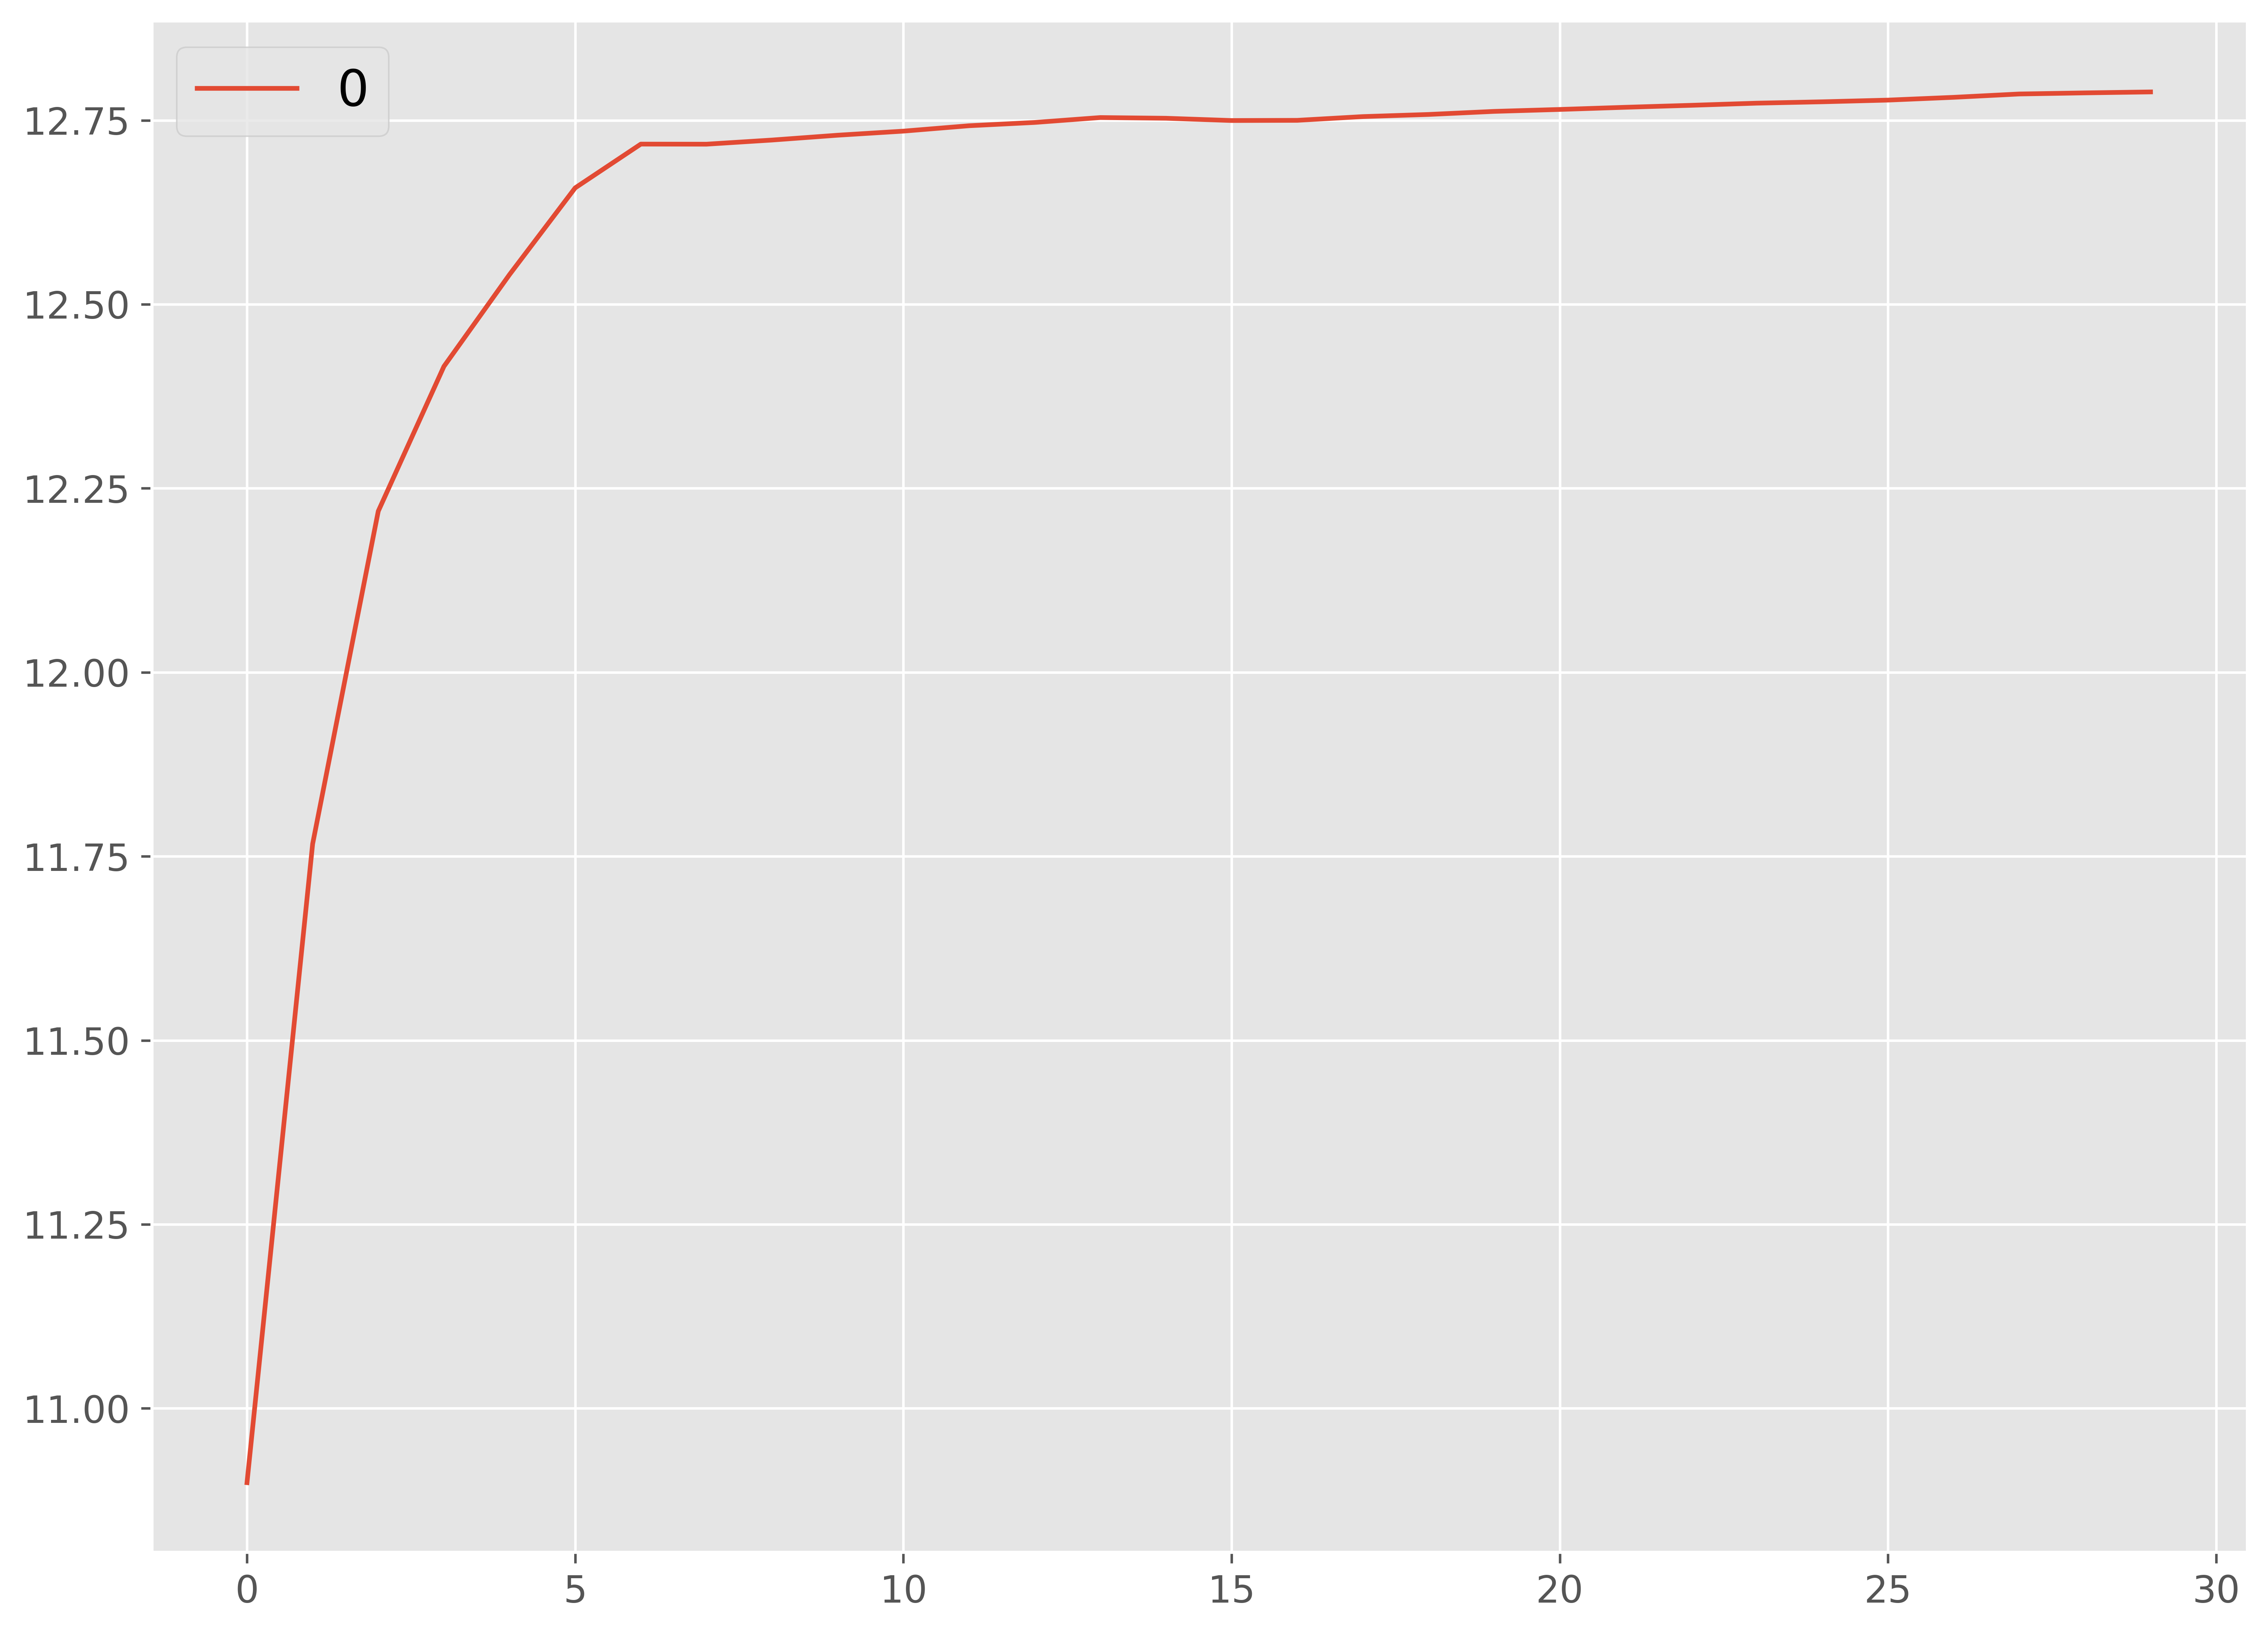

In [97]:
# MSE with log scale

rmse_val = [] #to store rmse values for different k
for K in range(30):
    K = K+1
    model = KNeighborsRegressor(n_neighbors = K)
    model.fit(X_train, y_train)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = log10(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

curve = pd.DataFrame(rmse_val) #elbow curve
curve.plot()

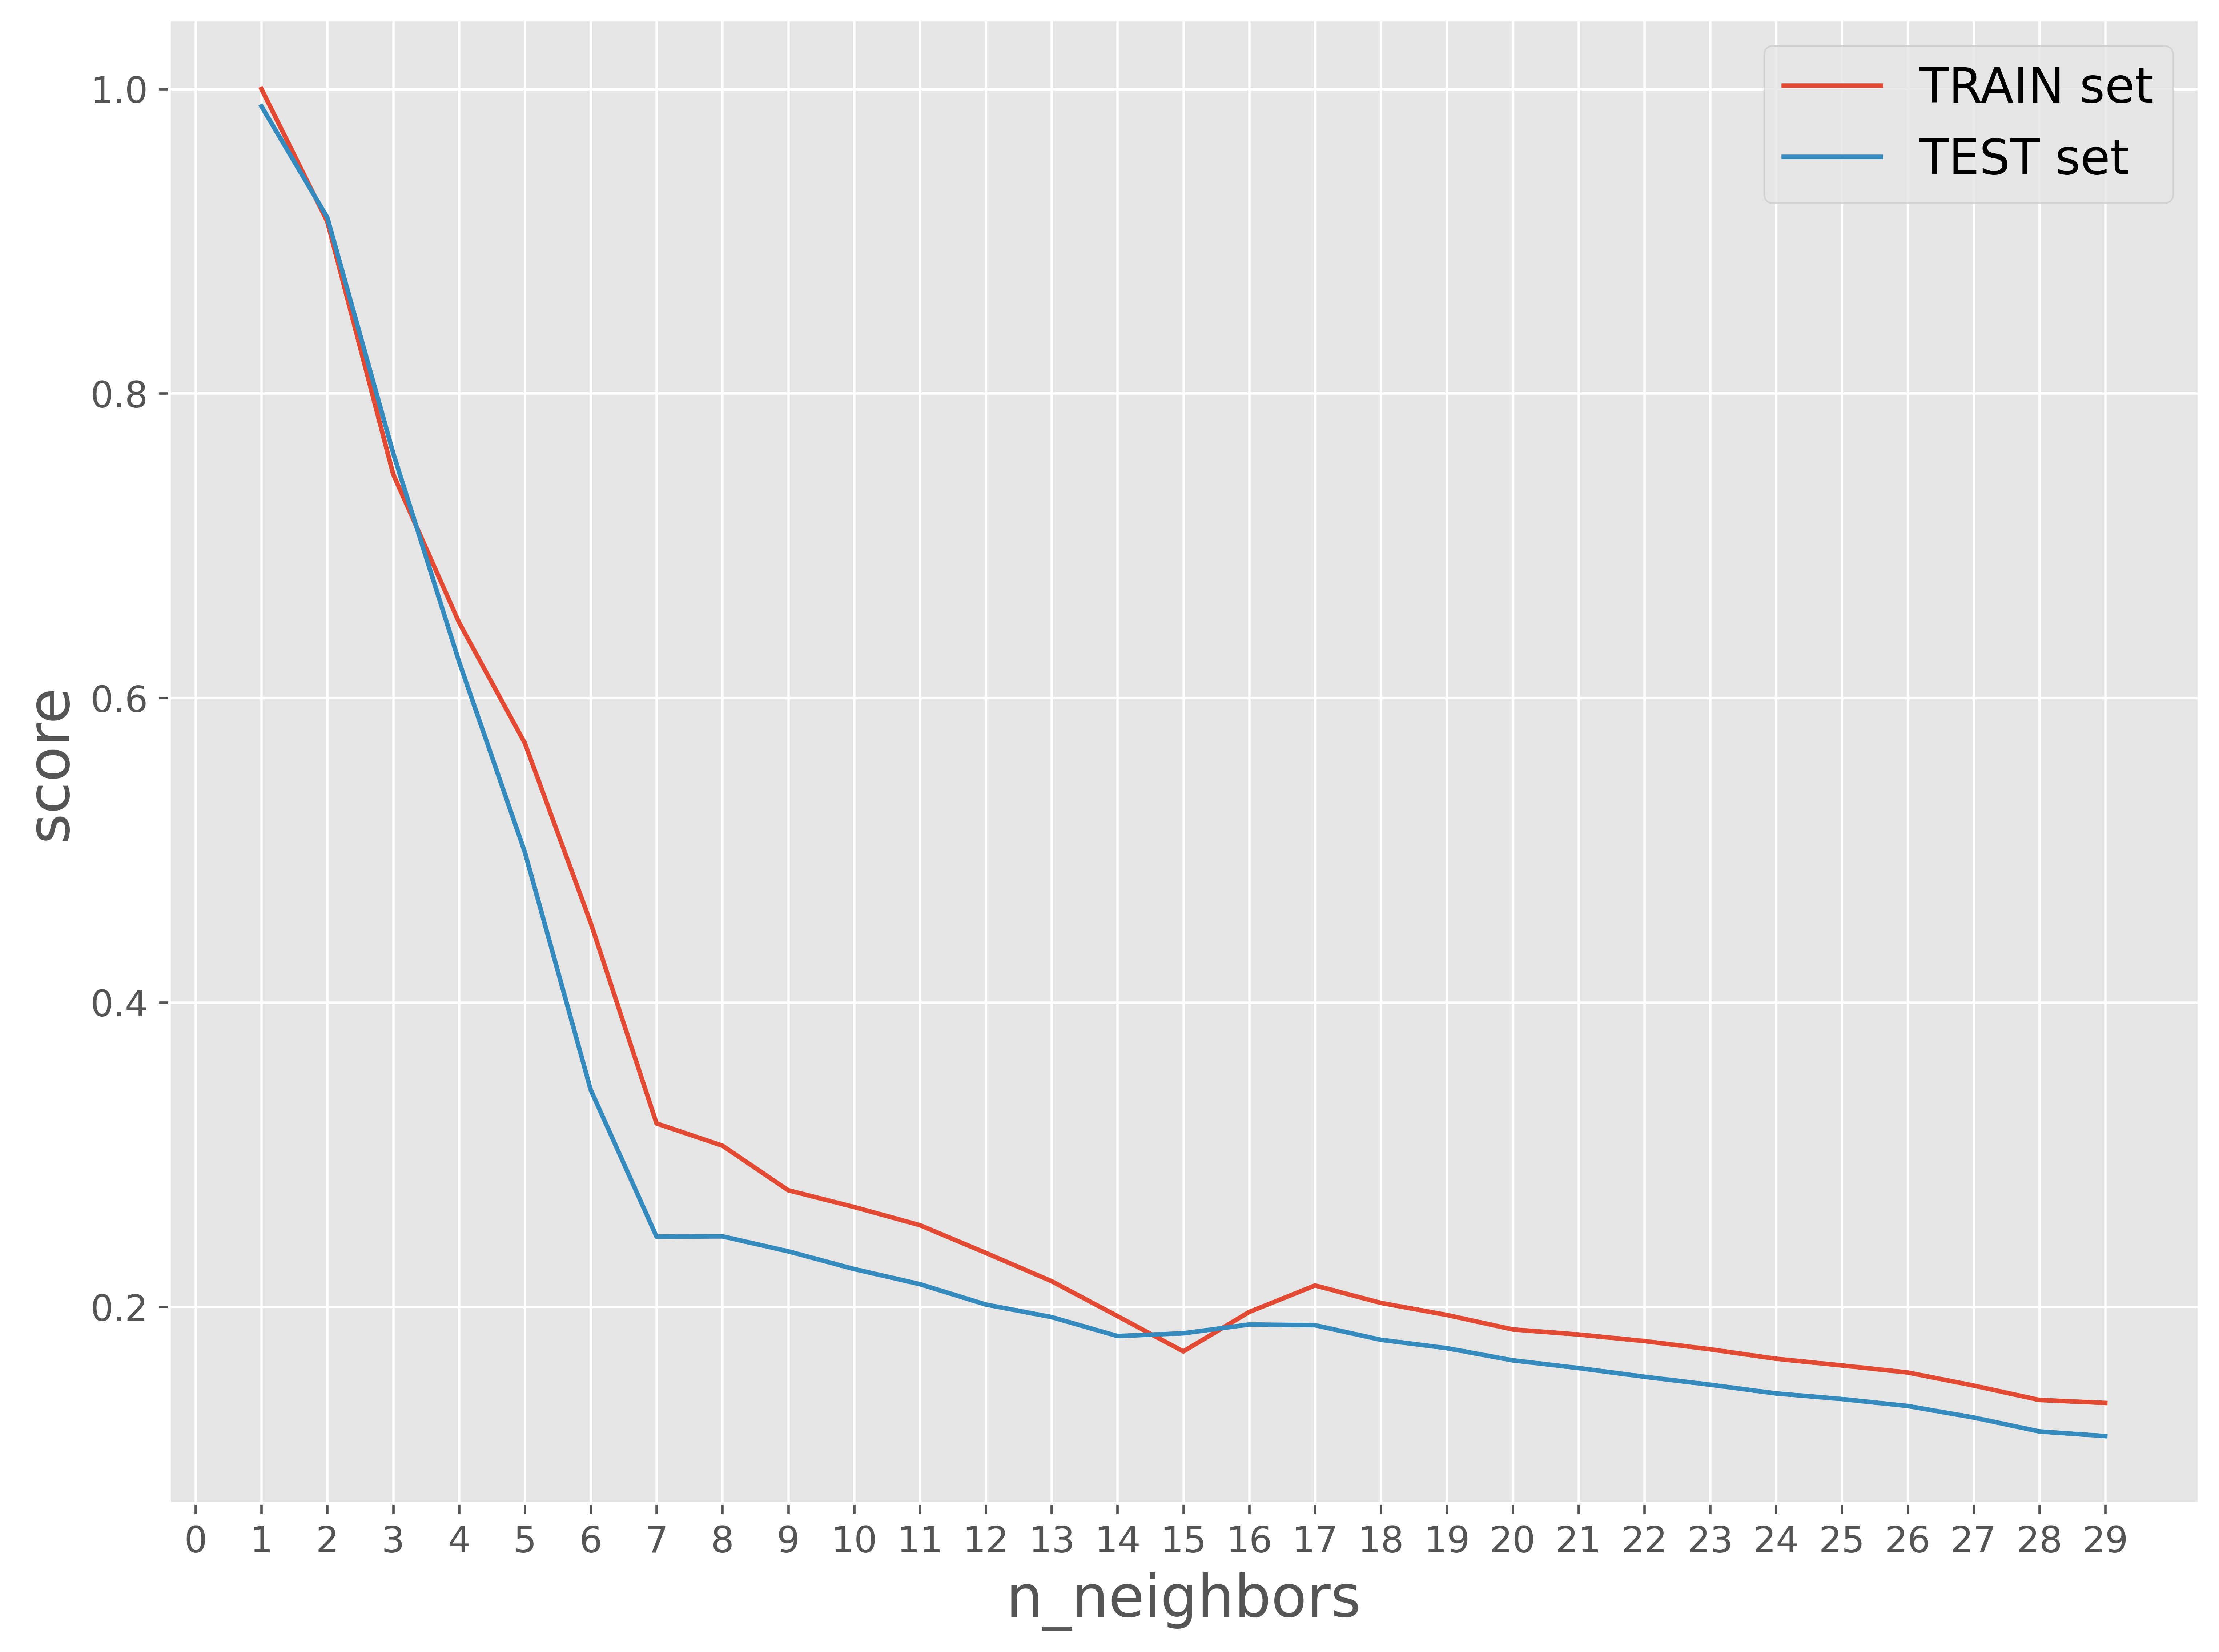

In [99]:
clf = KNeighborsRegressor()
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)

y_test=np.ravel(y_test)

train_acc = []
test_acc = []

for n in range(1,30):
    clf = KNeighborsRegressor(n_jobs=-1, n_neighbors=n)
    clf.fit(X_train, y_train)
    prediction = clf.predict(X_test)
    train_acc.append(clf.score(X_train, y_train))
    test_acc.append(clf.score(X_test, y_test))

plt.figure(figsize=(12, 9))
plt.plot(range(1, 30), train_acc, label='TRAIN set')
plt.plot(range(1, 30), test_acc, label='TEST set')
plt.xlabel("n_neighbors")
plt.ylabel("score")
plt.xticks(np.arange(0, 30, step=1))
plt.legend()
plt.show()

In [88]:
n_neighbors = 10
random_state = 7777

# Load Digits dataset

In [100]:
X = test_df.drop(["Maximum Installs", "Installs", "Released"], axis = 1)
y = test_df[['Installs']]

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=random_state
)

In [90]:
X_test

Category  Rating  Rating Count     Size  Minimum Android  \
17372       8.0     0.0           0.0    0.193             25.0   
3402        8.0     4.8           5.0   12.000             21.0   
3904        8.0     4.4           7.0  126.000             27.0   
10230       8.0     0.0           0.0    8.500             16.0   
1912       15.0     0.0           0.0   16.000             27.0   
...         ...     ...           ...      ...              ...   
7629        4.0     3.9          25.0   28.000             27.0   
9228        8.0     0.0           0.0    4.500             21.0   
3614        2.0     0.0           0.0    2.800             16.0   
19967      15.0     4.5         535.0    7.100             29.0   
18760      24.0     4.4          66.0    7.400             21.0   

       Content Rating  Ad Supported  In App Purchases  
17372             0.0           0.0               0.0  
3402              0.0           0.0               0.0  
3904              0.0           0.0               0.0  
10230             0.0           0.0               0.0  
1912              0.0           0.0               0.0  
...               ...           ...               ...  
7629              0.0           0.0               0.0  
9228              0.0           0.0               0.0  
3614              0.0           1.0               0.0  
19967             0.0           1.0               0.0  
18760             3.0           1.0               0.0  

[3779 rows x 8 columns]

In [103]:
def plotKNN(knn_model):


    # Reduce dimension to 2 with PCA
    pca = make_pipeline(StandardScaler(), PCA(n_components=2))

    # Use a nearest neighbor classifier to evaluate the methods
    knn = knn_model

    # Make a list of the methods to be compared
    dim_reduction_methods = [("PCA", pca)]

    # plt.figure()
    for i, (name, model) in enumerate(dim_reduction_methods):
        plt.figure()
        # plt.subplot(1, 3, i + 1, aspect=1)

        # Fit the method's model
        model.fit(X_train, y_train)

        # Fit a nearest neighbor classifier on the embedded training set
        knn.fit(model.transform(X_train), y_train)

        # Compute the nearest neighbor accuracy on the embedded test set
        acc_knn = knn.score(model.transform(X_test), y_test)

        # Embed the data set in 2 dimensions using the fitted model
        X_embedded = model.transform(X_test)

        # Plot the projected points and show the evaluation score
        plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_test["Installs"],s=30, cmap="Set1")
        plt.title(
            "{}, KNN (k={})\nTest accuracy = {:.2f}".format(name, knn.n_neighbors, acc_knn)
        )
    plt.show()

In [104]:
from sklearn.model_selection import RandomizedSearchCV


#Create KNN model
knn = KNeighborsClassifier()
#Set Kfold for k == 5
cv = KFold(n_splits=5)

ss = StandardScaler()

fold = 0
for train_index, test_index in cv.split(X_test):

    fold += 1
    train_X, test_X = X_train.iloc[train_index], X_test.iloc[test_index]
    train_y, test_y = y_train.iloc[train_index], y_test.iloc[test_index]


    #Predict value by KNN when k == 5
    model_n_7 = KNeighborsClassifier(n_neighbors = 7)
    model_n_7.fit(ss.fit_transform(train_X), train_y)

    print(f'Result of {fold} fold')
    print(f'Result when k == 5 => {model_n_7.score(ss.fit_transform(test_X), test_y)}')

Result of 1 fold
Result when k == 5 => 0.24867724867724866
Result of 2 fold
Result when k == 5 => 0.25
Result of 3 fold
Result when k == 5 => 0.23941798941798942
Result of 4 fold
Result when k == 5 => 0.21825396825396826
Result of 5 fold
Result when k == 5 => 0.247682119205298


--------With GridSearch--------


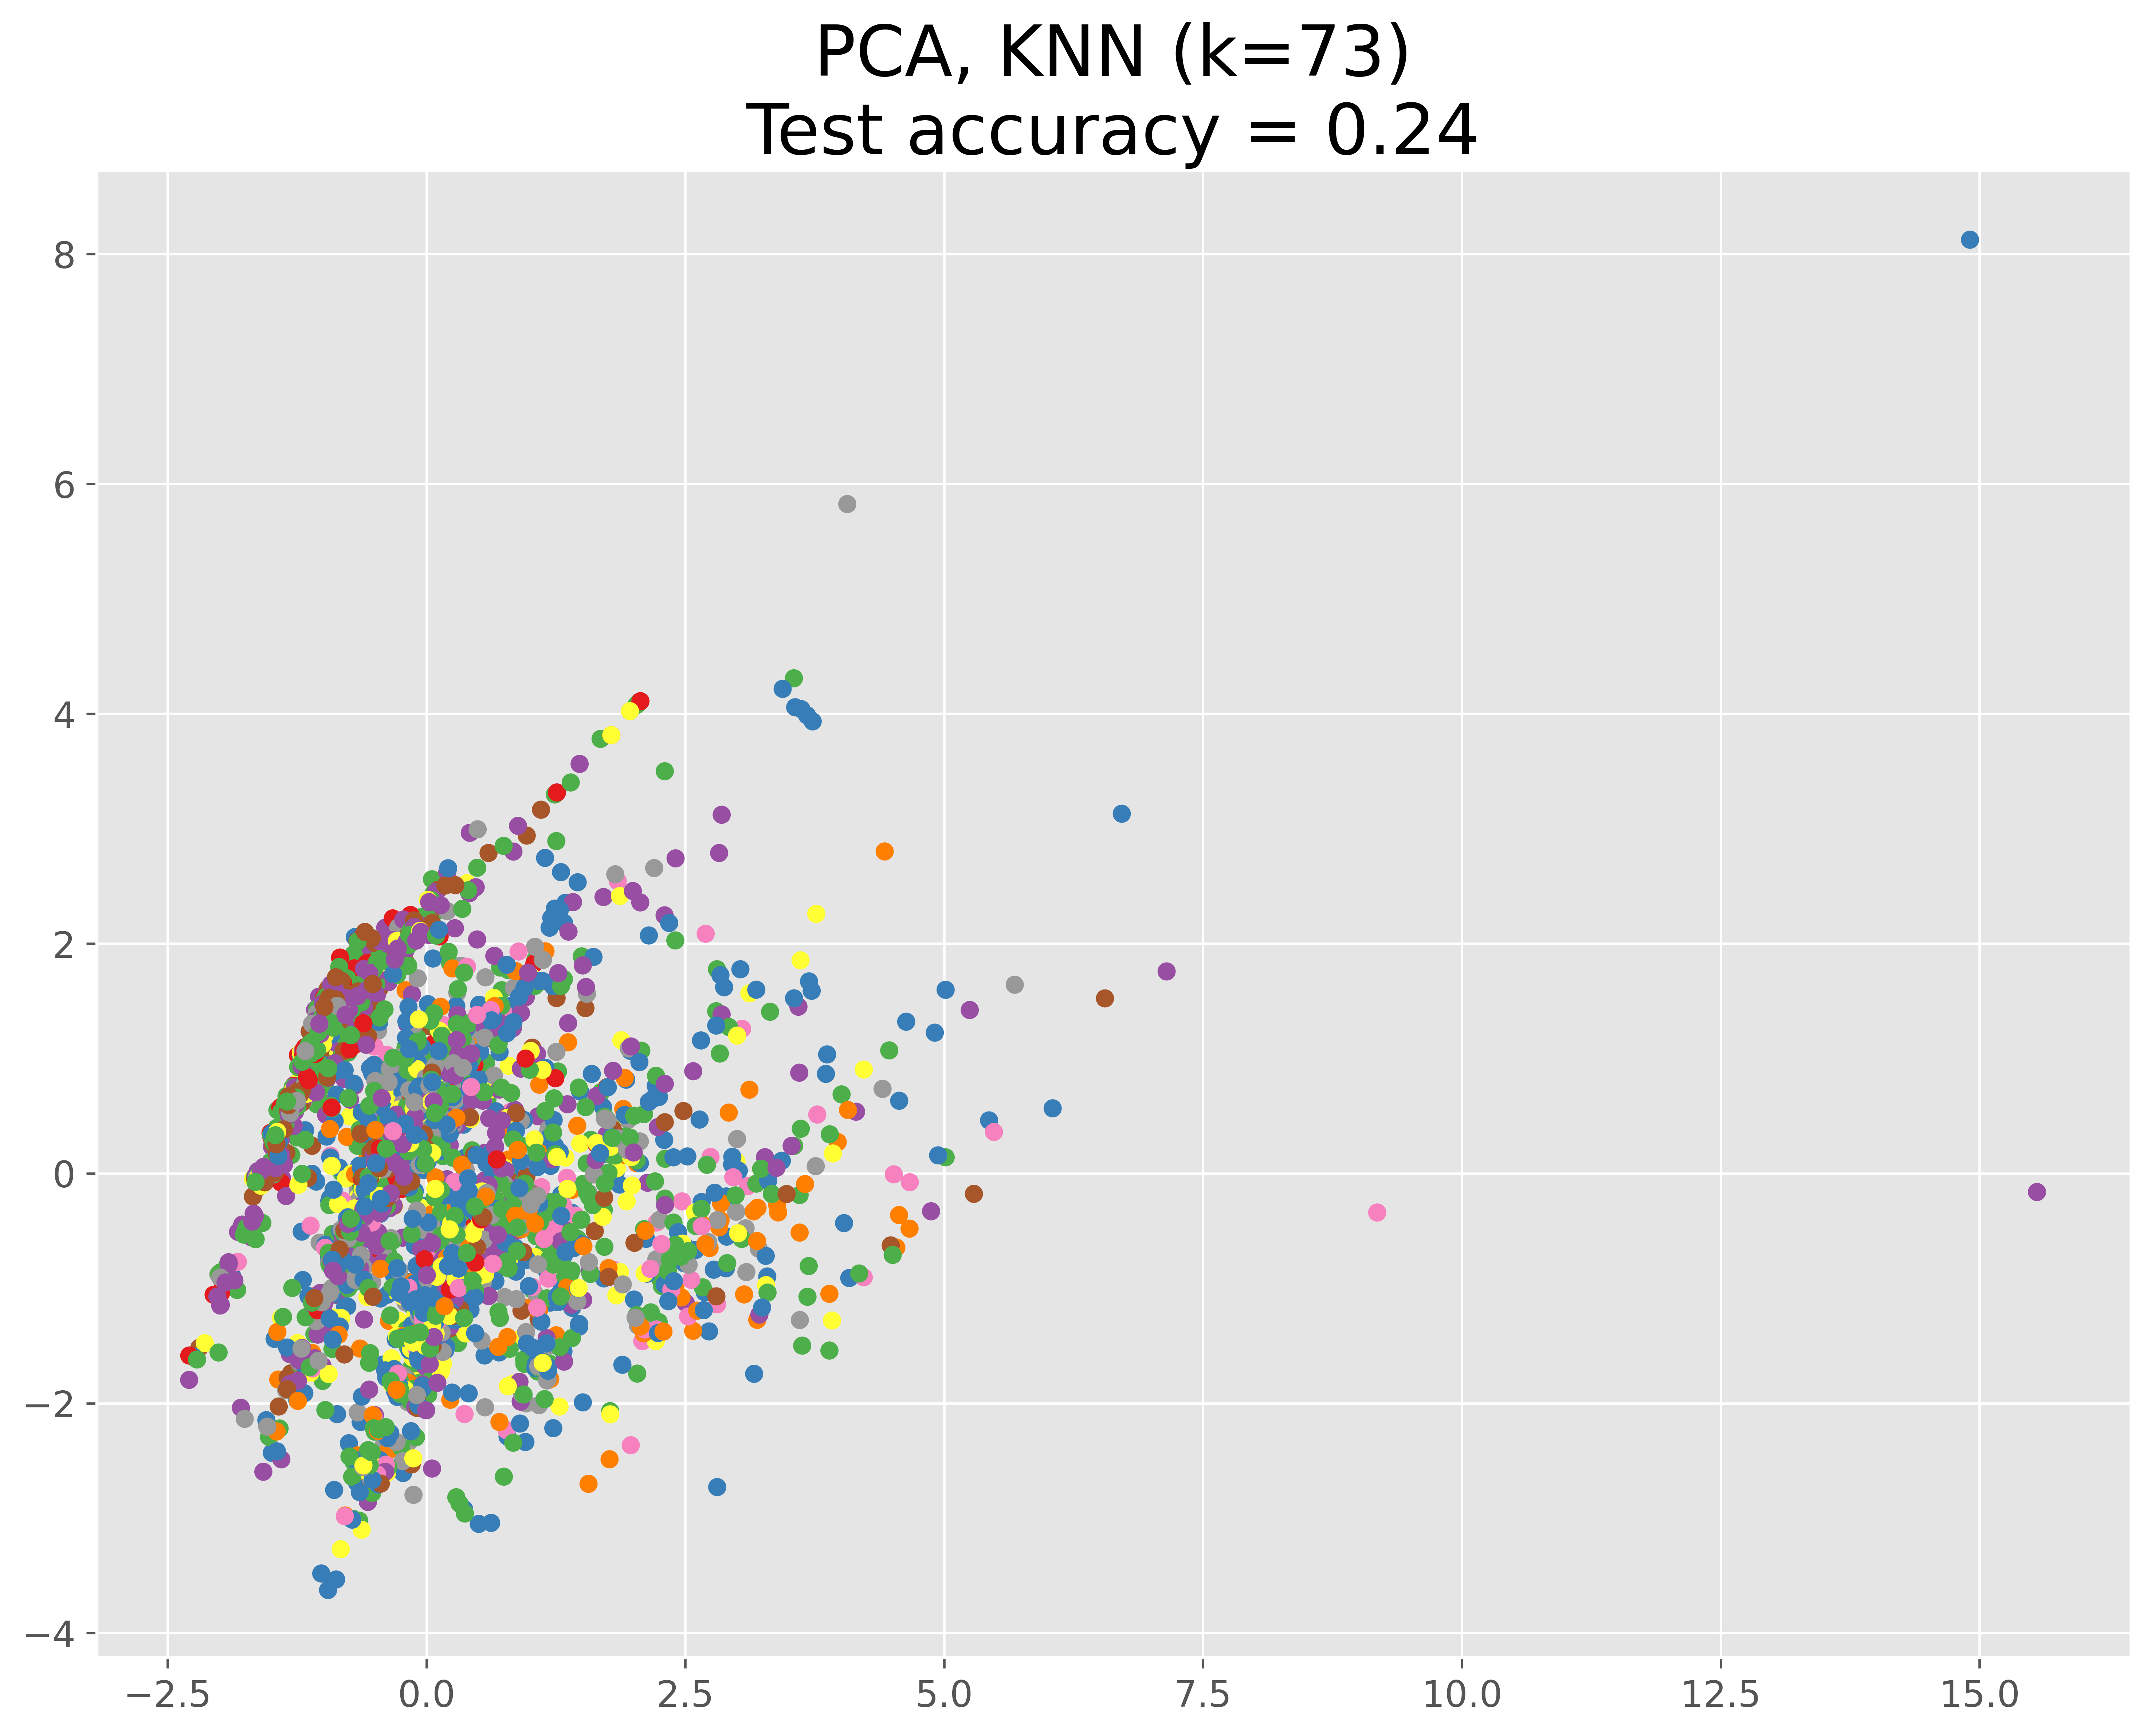

In [113]:

#Set neighbors matrix for grid searching
param_grid = dict(n_neighbors = np.arange(1, 100))

#Hyperparameter tuning by grid searching
print("--------With GridSearch--------")
grid_search = GridSearchCV(knn, param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(ss.fit_transform(X_train), y_train)
optimal_knn = grid_search.best_estimator_
plotKNN(optimal_knn)

print()

--------With Randomized GridSearch--------
Optimal k is 73


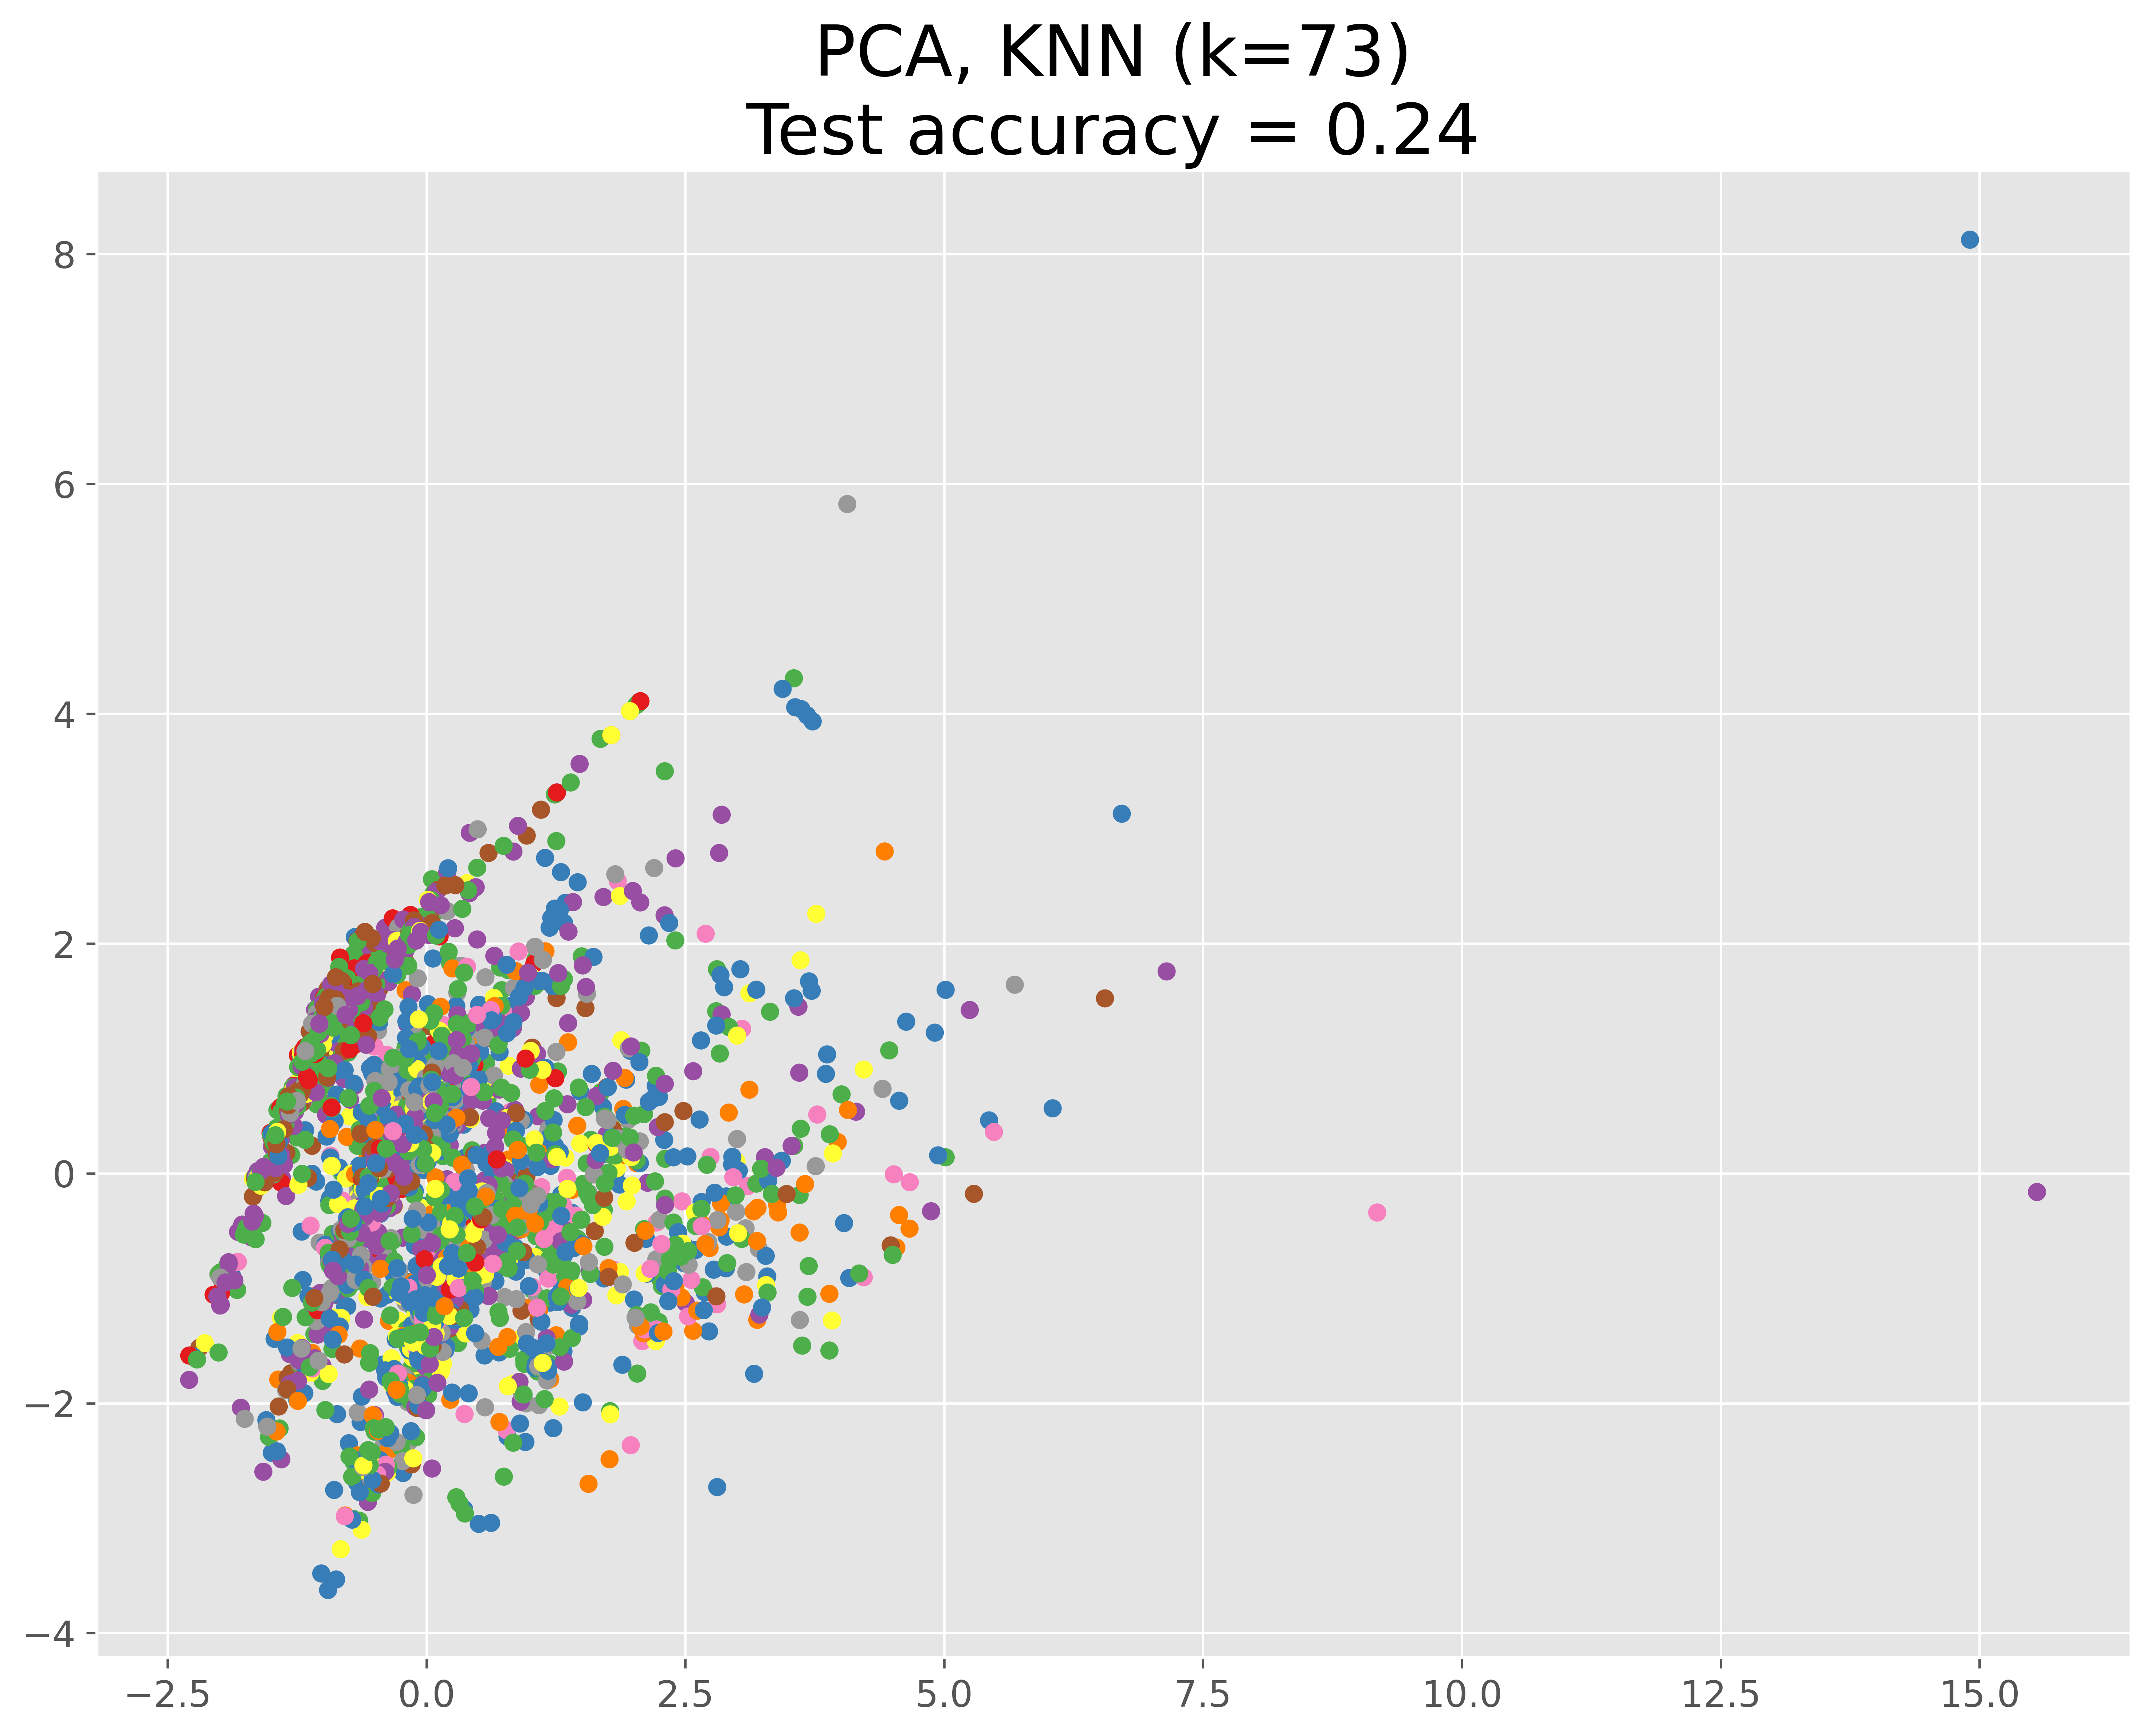

In [114]:
#Hyperparameter tuning by randomized grid searching
print("--------With Randomized GridSearch--------")
randomized_grid_search = RandomizedSearchCV(knn, param_grid, scoring='accuracy', n_jobs=-1, cv=5)
randomized_grid_search.fit(ss.fit_transform(X_train), y_train)
optimal_knn = grid_search.best_estimator_
print(f'Optimal k is {optimal_knn.n_neighbors}')
plotKNN(optimal_knn)
print()
